# Validation on Combined External Datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
import numpy as np
import pickle
import shap
import statsmodels.api as sm
from pathlib import Path

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from src.data.loading import load_sklearn_models_and_metadata
from src.config.constants import NUMERICAL_FEATURES
from src.config.paths import DNN_DIR, BENCHMARKING_DIR, SKLEARN_DIR

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the models and scaler
model = keras.saving.load_model(DNN_DIR / "exports" / "IFM-1_2025-04-24.keras")
scaler = joblib.load(DNN_DIR / "exports" / "scaler_2025-04-24.pkl")

# Load explainer for SHAP analysis
with open(DNN_DIR / "exports" / "shap_explainer_2025-04-24.pkl", "rb") as f:
    explainer = pickle.load(f)


In [3]:

# Define paths to the preprocessed validation datasets
spain_data_path = Path("output/validation/spain/preprocessed_data.csv")
scotland_data_path = Path("output/validation/scotland/preprocessed_data.csv")
australia_data_path = Path("output/validation/australia/preprocessed_data.csv")

# First, we need to save the preprocessed X and y data from each validation notebook
# This code would be added to each validation notebook at the end
# X_spain.to_csv(spain_data_path.parent / "X_spain.csv", index=False)
# pd.Series(y_spain).to_csv(spain_data_path.parent / "y_spain.csv", index=False)
# Similar code for Scotland and Australia

# Load the validation datasets
# Load Spain data
X_spain = pd.read_csv(spain_data_path.parent / "X_spain.csv")
y_spain = pd.read_csv(spain_data_path.parent / "y_spain.csv").squeeze()

# Load Scotland data
X_scotland = pd.read_csv(scotland_data_path.parent / "X_scotland.csv")
y_scotland = pd.read_csv(scotland_data_path.parent / "y_scotland.csv").squeeze()

# Load Australia data
X_australia = pd.read_csv(australia_data_path.parent / "X_australia.csv")
y_australia = pd.read_csv(australia_data_path.parent / "y_australia.csv").squeeze()

# Combine the datasets with a new column indicating the source
X_spain['validation_source'] = 'Spain'
X_scotland['validation_source'] = 'Scotland'
X_australia['validation_source'] = 'Australia'

# Combine X and y data
X_combined = pd.concat([X_spain, X_scotland, X_australia], ignore_index=True)
y_combined = pd.concat([y_spain, y_scotland, y_australia], ignore_index=True)

# Print dataset sizes
print(f"Spain dataset: {len(X_spain)} samples")
print(f"Scotland dataset: {len(X_scotland)} samples")
print(f"Australia dataset: {len(X_australia)} samples")
print(f"Combined dataset: {len(X_combined)} samples")


Spain dataset: 101 samples
Scotland dataset: 53 samples
Australia dataset: 90 samples
Combined dataset: 244 samples


In [4]:

# Get the validation source for reference
validation_source = X_combined['validation_source'].copy()
X_combined = X_combined.drop(columns=['validation_source'])


In [5]:

# Verify all datasets have the same columns
print(f"Columns match between all datasets: {set(X_spain.columns) == set(X_scotland.columns) == set(X_australia.columns)}")


Columns match between all datasets: True


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

Classification Report (Combined Dataset):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       158
           1       0.56      0.56      0.56        86

    accuracy                           0.69       244
   macro avg       0.66      0.66      0.66       244
weighted avg       0.69      0.69      0.69       244



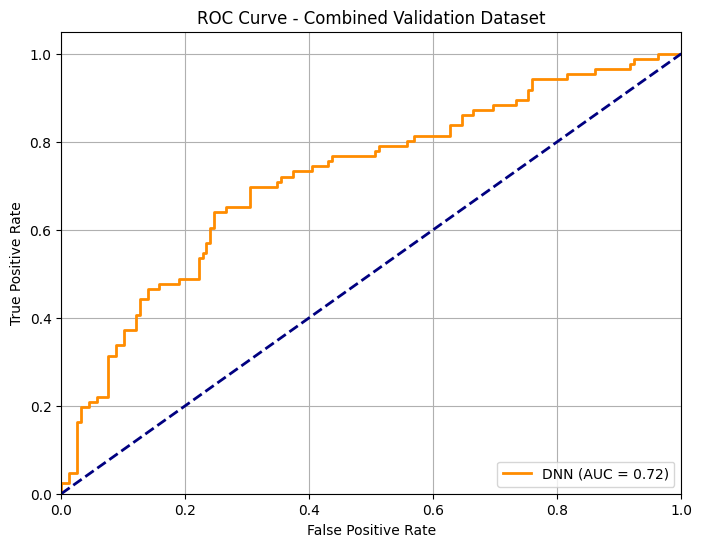

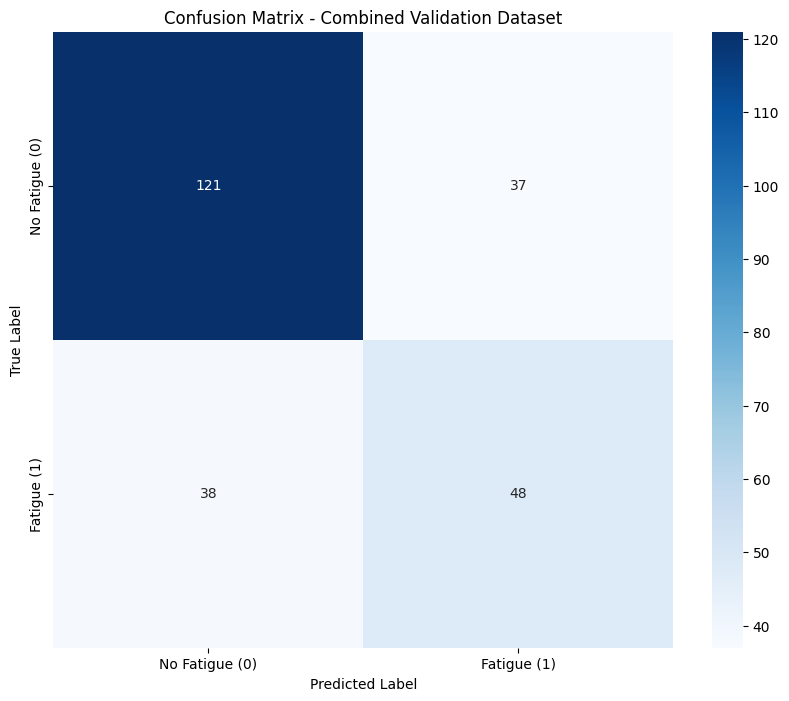


Detailed Metrics (Combined Dataset):
Specificity (True Negative Rate): 0.766
Sensitivity (True Positive Rate): 0.558
Positive Predictive Value: 0.565
Negative Predictive Value: 0.761


In [6]:

# Evaluate the DNN model on the combined dataset
# Get probability predictions
y_pred_proba = model.predict(X_combined)
# Get binary predictions using 0.5 threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

# Print classification report
print("\nClassification Report (Combined Dataset):")
print(classification_report(y_combined, y_pred))

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_combined, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f'DNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined Validation Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Create and plot confusion matrix
cm = confusion_matrix(y_combined, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fatigue (0)", "Fatigue (1)"],
            yticklabels=["No Fatigue (0)", "Fatigue (1)"])
plt.title("Confusion Matrix - Combined Validation Dataset")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nDetailed Metrics (Combined Dataset):")
print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")
print(f"Positive Predictive Value: {ppv:.3f}")
print(f"Negative Predictive Value: {npv:.3f}")

# Per-country performance analysis
countries = ['Spain', 'Scotland', 'Australia']
country_metrics = []

for country in countries:
    mask = validation_source == country
    X_country = X_combined[mask]
    y_country = y_combined[mask]
    
    # Get predictions for this country
    y_pred_country = y_pred[mask]
    y_pred_proba_country = y_pred_proba[mask]
    
    # Calculate metrics
    country_cm = confusion_matrix(y_country, y_pred_country)
    tn, fp, fn, tp = country_cm.ravel()
    
    # Calculate ROC and AUC
    fpr_country, tpr_country, _ = roc_curve(y_country, y_pred_proba_country)
    roc_auc_country = auc(fpr_country, tpr_country)
    
    country_metrics.append({
        'Country': country,
        'Samples': len(X_country),
        'AUC': roc_auc_country,
        'Accuracy': (tp + tn) / (tp + tn + fp + fn),
        'Sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'PPV': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'NPV': tn / (tn + fn) if (tn + fn) > 0 else 0
    })



Per-Country Performance:
     Country  Samples    AUC  Accuracy  Sensitivity  Specificity    PPV    NPV
0      Spain      101  0.754     0.752        0.571        0.800  0.429  0.877
1   Scotland       53  0.654     0.585        0.433        0.783  0.722  0.514
2  Australia       90  0.774     0.689        0.657        0.709  0.590  0.765


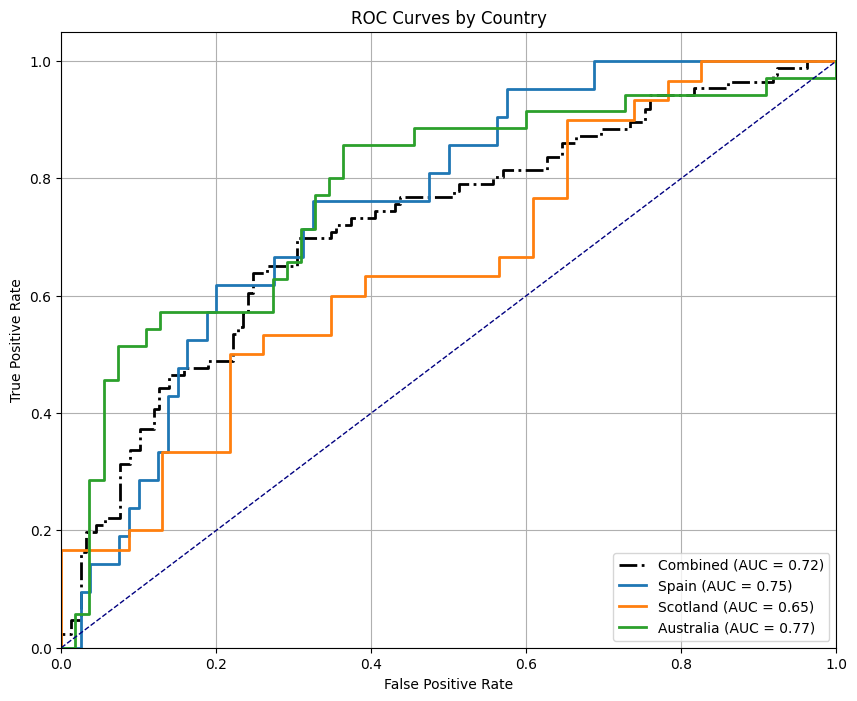

In [7]:

# Create dataframe of country metrics
country_metrics_df = pd.DataFrame(country_metrics)
print("\nPer-Country Performance:")
print(country_metrics_df.round(3))

# Plot per-country ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="black", lw=2, linestyle="-.", label=f'Combined (AUC = {roc_auc:.2f})')

for country in countries:
    mask = validation_source == country
    y_country = y_combined[mask]
    y_pred_proba_country = y_pred_proba[mask]
    
    fpr_country, tpr_country, _ = roc_curve(y_country, y_pred_proba_country)
    roc_auc_country = auc(fpr_country, tpr_country)
    
    plt.plot(fpr_country, tpr_country, lw=2, 
             label=f'{country} (AUC = {roc_auc_country:.2f})')

plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Country")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [8]:

# Evaluate other models (sklearn models and logistic regression)
# This part is similar to the spain validation notebook
try:
    # Load sklearn models
    sklearn_models_dir = SKLEARN_DIR / "exports"
    sklearn_models, sklearn_scaler, sklearn_feature_names = load_sklearn_models_and_metadata(sklearn_models_dir)
    
    # Load logistic regression model
    with open(BENCHMARKING_DIR / "statsmodels_logreg.pkl", 'rb') as f:
        logreg_model = pickle.load(f)
    
    # Prepare data for statsmodels prediction
    X_combined_const = sm.add_constant(X_combined, has_constant="add")
    
    # Ensure columns match the model's parameters
    missing_cols = set(logreg_model.params.index) - set(X_combined_const.columns)
    for c in missing_cols:
        X_combined_const[c] = 0
    X_combined_const = X_combined_const[logreg_model.params.index]
    
    # Get probability predictions for Logistic Regression
    y_pred_proba_logreg = logreg_model.predict(X_combined_const)
    
    # Calculate ROC and AUC for logistic regression
    fpr_logreg, tpr_logreg, _ = roc_curve(y_combined, y_pred_proba_logreg)
    roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
    
    # Create metrics list for all models
    metrics_list = []
    
    # Add DNN metrics
    metrics_list.append({
        "Model": "Deep Neural Network",
        "AUC": roc_auc,
        "Accuracy": (tp + tn) / (tp + tn + fp + fn),
        "Sensitivity": sensitivity,
        "Specificity": specificity
    })
    
    # Add LogReg metrics
    logreg_preds = (y_pred_proba_logreg >= 0.5).astype(int)
    logreg_cm = confusion_matrix(y_combined, logreg_preds)
    logreg_tn, logreg_fp, logreg_fn, logreg_tp = logreg_cm.ravel()
    
    metrics_list.append({
        "Model": "Logistic Regression (statsmodels)",
        "AUC": roc_auc_logreg,
        "Accuracy": (logreg_tp + logreg_tn) / (logreg_tp + logreg_tn + logreg_fp + logreg_fn),
        "Sensitivity": logreg_tp / (logreg_tp + logreg_fn) if (logreg_tp + logreg_fn) > 0 else 0,
        "Specificity": logreg_tn / (logreg_tn + logreg_fp) if (logreg_tn + logreg_fp) > 0 else 0
    })
    
    # Add sklearn models metrics
    X_combined_sklearn = X_combined[sklearn_feature_names].copy()
    
    for model_name, model in sklearn_models.items():
        print(f"Evaluating {model_name}...")
        
        # Make predictions
        if hasattr(model, "predict_proba"):
            try:
                y_pred_proba_sklearn = model.predict_proba(X_combined_sklearn)[:, 1]
            except IndexError:
                y_pred_proba_sklearn = model.predict_proba(X_combined_sklearn)
        else:
            decision_values = model.decision_function(X_combined_sklearn)
            y_pred_proba_sklearn = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())
        
        y_pred_sklearn = (y_pred_proba_sklearn >= 0.5).astype(int)
        
        # Calculate metrics
        fpr_sklearn, tpr_sklearn, _ = roc_curve(y_combined, y_pred_proba_sklearn)
        roc_auc_sklearn = auc(fpr_sklearn, tpr_sklearn)
        
        # Calculate confusion matrix
        cm_sklearn = confusion_matrix(y_combined, y_pred_sklearn)
        tn_sklearn, fp_sklearn, fn_sklearn, tp_sklearn = cm_sklearn.ravel()
        
        metrics_list.append({
            "Model": model_name,
            "AUC": roc_auc_sklearn,
            "Accuracy": (tp_sklearn + tn_sklearn) / (tp_sklearn + tn_sklearn + fp_sklearn + fn_sklearn),
            "Sensitivity": tp_sklearn / (tp_sklearn + fn_sklearn) if (tp_sklearn + fn_sklearn) > 0 else 0,
            "Specificity": tn_sklearn / (tn_sklearn + fp_sklearn) if (tn_sklearn + fp_sklearn) > 0 else 0
        })
    
    # Create dataframe and sort by AUC
    metrics_df = pd.DataFrame(metrics_list).sort_values("AUC", ascending=False)
    metrics_df = metrics_df.round(3)
    
    # Display metrics
    print("\nModel Performance on Combined Validation Dataset:")
    print(metrics_df)
    
    # Save metrics to CSV
    metrics_output_path = Path("output/validation/combined")
    metrics_output_path.mkdir(parents=True, exist_ok=True)
    metrics_df.to_csv(metrics_output_path / "combined_validation_metrics.csv", index=False)
    
except Exception as e:
    print(f"Error loading or evaluating models: {e}")


Evaluating Svc...
Evaluating Mlpclassifier...
Evaluating Xgboost...
Evaluating Random Forest...
Evaluating Adaboost...
Evaluating Logistic Regression...

Model Performance on Combined Validation Dataset:
                               Model    AUC  Accuracy  Sensitivity  \
7                Logistic Regression  0.751     0.730        0.465   
3                      Mlpclassifier  0.743     0.738        0.419   
2                                Svc  0.733     0.730        0.512   
1  Logistic Regression (statsmodels)  0.731     0.709        0.453   
0                Deep Neural Network  0.720     0.689        0.558   
6                           Adaboost  0.715     0.676        0.256   
4                            Xgboost  0.707     0.713        0.395   
5                      Random Forest  0.692     0.697        0.349   

   Specificity  
7        0.873  
3        0.911  
2        0.848  
1        0.848  
0        0.766  
6        0.905  
4        0.886  
5        0.886  


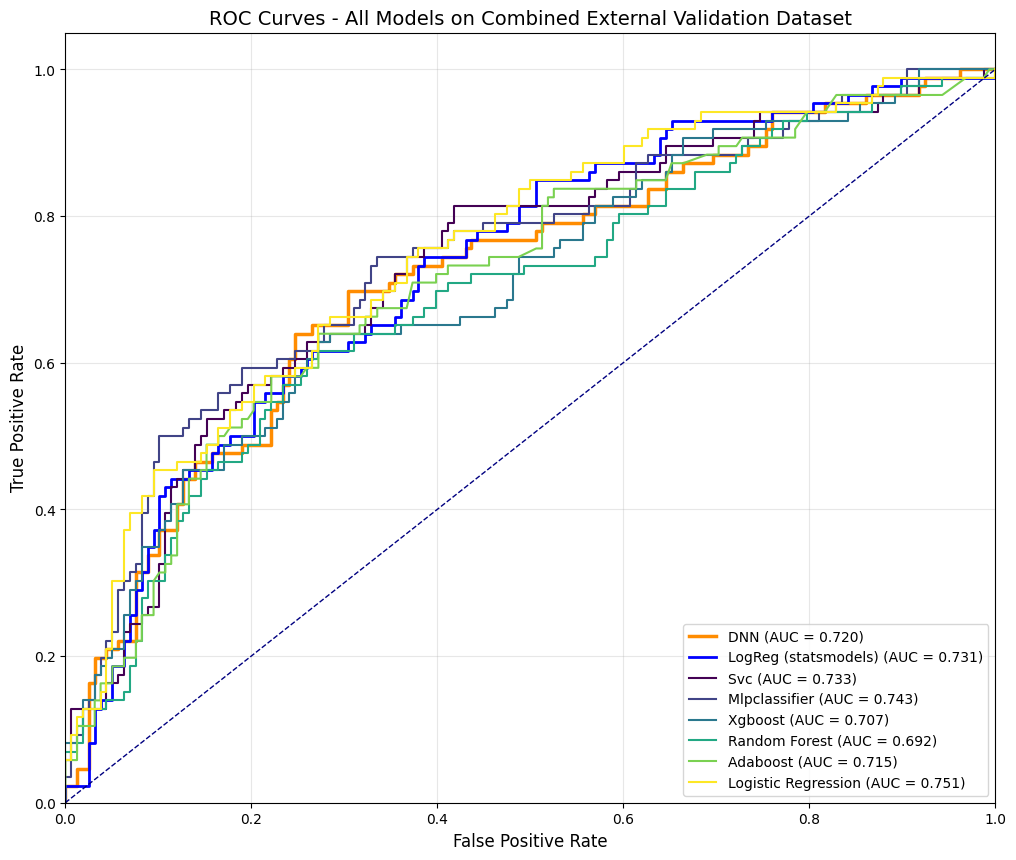

In [11]:
# Plot combined ROC curves for all models
plt.figure(figsize=(12, 10))

# Plot DNN ROC curve
plt.plot(fpr, tpr, lw=2.5, label=f'DNN (AUC = {roc_auc:.3f})', color='darkorange')

# Plot Logistic Regression ROC curve if available
try:
    plt.plot(fpr_logreg, tpr_logreg, lw=2, label=f'LogReg (statsmodels) (AUC = {roc_auc_logreg:.3f})', color='blue')
    
    # Plot sklearn models
    colors = plt.cm.viridis(np.linspace(0, 1, len(sklearn_models)))
    
    for (model_name, model), color in zip(sklearn_models.items(), colors):
        # Calculate predictions if not already done
        if hasattr(model, "predict_proba"):
            try:
                y_pred_proba_model = model.predict_proba(X_combined_sklearn)[:, 1]
            except IndexError:
                y_pred_proba_model = model.predict_proba(X_combined_sklearn)
        else:
            decision_values = model.decision_function(X_combined_sklearn)
            y_pred_proba_model = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())
        
        # Calculate ROC curve
        fpr_model, tpr_model, _ = roc_curve(y_combined, y_pred_proba_model)
        roc_auc_model = auc(fpr_model, tpr_model)
        
        # Plot ROC curve for this model
        plt.plot(
            fpr_model, tpr_model, lw=1.5, 
            label=f'{model_name} (AUC = {roc_auc_model:.3f})',
            color=color
        )
        
except NameError:
    print("Logistic regression or sklearn models not available")
except Exception as e:
    print(f"Error plotting model ROC curves: {e}")

# Add diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models on Combined External Validation Dataset', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)

# Save the plot
metrics_output_path = Path("output/validation/combined")
metrics_output_path.mkdir(parents=True, exist_ok=True)
plt.savefig(metrics_output_path / "combined_all_models_roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()


Analyzing model agreement on combined validation dataset:


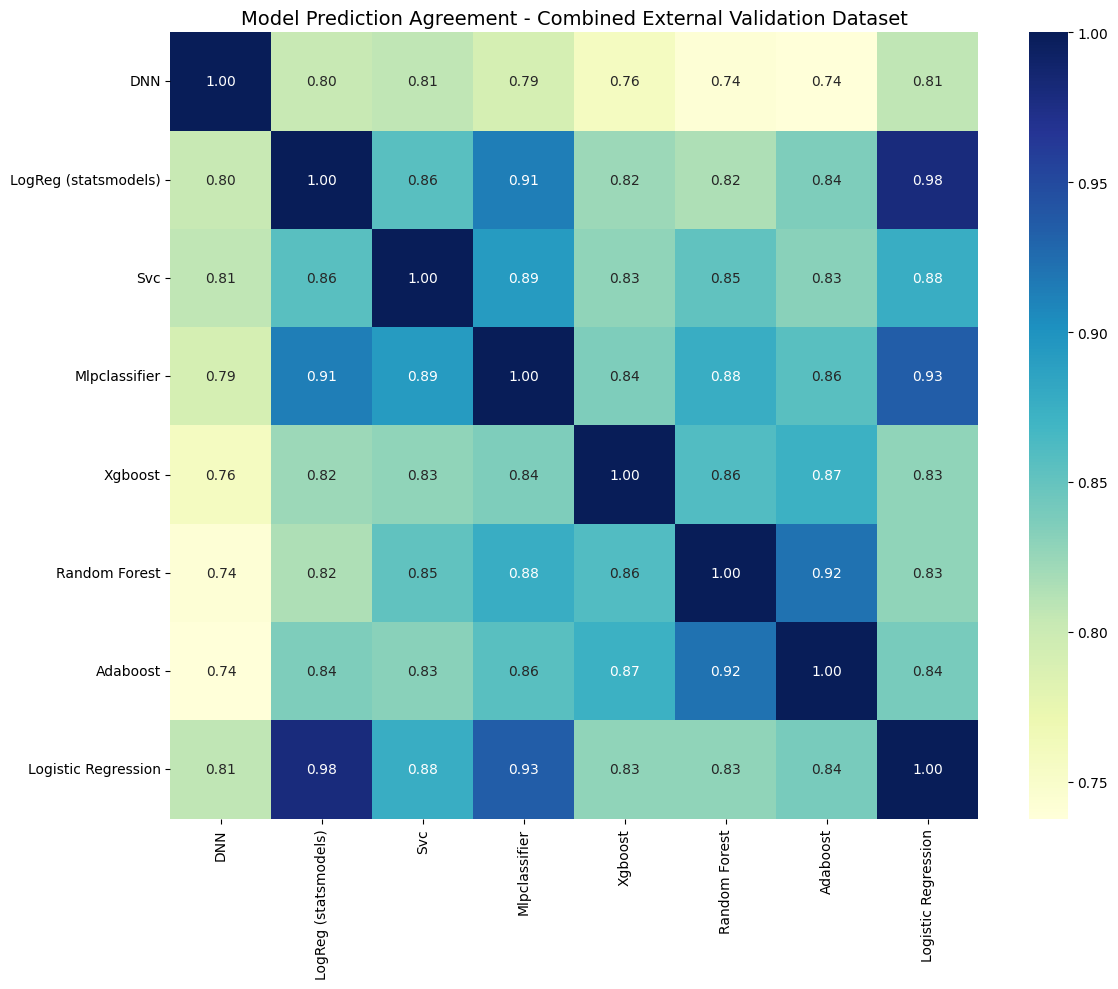


Analyzing model agreement by country:

--- Spain Dataset ---
Top 3 model agreements in Spain:
  LogReg (statsmodels) vs Logistic Regression: 0.96
  Logistic Regression vs LogReg (statsmodels): 0.96
  Random Forest vs Adaboost: 0.94
Bottom 3 model agreements in Spain:
  Adaboost vs DNN: 0.78
  DNN vs Xgboost: 0.75
  Xgboost vs DNN: 0.75

--- Scotland Dataset ---
Top 3 model agreements in Scotland:
  LogReg (statsmodels) vs Logistic Regression: 1.00
  Logistic Regression vs LogReg (statsmodels): 1.00
  LogReg (statsmodels) vs Mlpclassifier: 0.92
Bottom 3 model agreements in Scotland:
  Adaboost vs Svc: 0.77
  DNN vs Random Forest: 0.75
  Random Forest vs DNN: 0.75

--- Australia Dataset ---
Top 3 model agreements in Australia:
  LogReg (statsmodels) vs Logistic Regression: 0.99
  Logistic Regression vs LogReg (statsmodels): 0.99
  Mlpclassifier vs Logistic Regression: 0.94
Bottom 3 model agreements in Australia:
  DNN vs Adaboost: 0.67
  Random Forest vs DNN: 0.67
  Adaboost vs DNN: 0.6

In [12]:
# Analyze model agreement across all validation datasets
try:
    # Check if we have both the DNN and other models available
    has_other_models = 'logreg_model' in locals() and len(sklearn_models) > 0
    
    if has_other_models:
        print("\nAnalyzing model agreement on combined validation dataset:")
        
        # Initialize with DNN predictions
        all_predictions = {
            "DNN": y_pred.flatten()
        }
        
        # Add LogReg predictions
        all_predictions["LogReg (statsmodels)"] = (y_pred_proba_logreg >= 0.5).astype(int)
        
        # Add sklearn models predictions
        for model_name, model in sklearn_models.items():
            # Get predictions
            if hasattr(model, "predict_proba"):
                try:
                    y_pred_proba_model = model.predict_proba(X_combined_sklearn)[:, 1]
                except IndexError:
                    y_pred_proba_model = model.predict_proba(X_combined_sklearn)
            else:
                decision_values = model.decision_function(X_combined_sklearn)
                y_pred_proba_model = (decision_values - decision_values.min()) / (decision_values.max() - decision_values.min())
            
            all_predictions[model_name] = (y_pred_proba_model >= 0.5).astype(int)
        
        # Create agreement matrix
        agreement_df = pd.DataFrame(all_predictions)
        
        # Calculate pairwise agreement percentages
        model_names = list(all_predictions.keys())
        agreement_matrix = np.zeros((len(model_names), len(model_names)))
        
        for i, model1 in enumerate(model_names):
            for j, model2 in enumerate(model_names):
                if i == j:
                    agreement_matrix[i, j] = 1.0  # Full agreement with self
                else:
                    # Calculate percentage of matching predictions
                    agreement_matrix[i, j] = np.mean(all_predictions[model1] == all_predictions[model2])
        
        # Create and display agreement heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            agreement_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="YlGnBu",
            xticklabels=model_names,
            yticklabels=model_names
        )
        plt.title("Model Prediction Agreement - Combined External Validation Dataset", fontsize=14)
        plt.tight_layout()
        plt.savefig(metrics_output_path / "combined_model_agreement.png", dpi=300, bbox_inches="tight")
        plt.show()
        
        # Add per-country agreement analysis
        print("\nAnalyzing model agreement by country:")
        for country in countries:
            print(f"\n--- {country} Dataset ---")
            country_mask = validation_source == country
            
            # Calculate agreement percentages for this country
            country_agreement = {}
            for model1 in model_names:
                for model2 in model_names:
                    if model1 != model2:
                        country_preds1 = all_predictions[model1][country_mask]
                        country_preds2 = all_predictions[model2][country_mask]
                        agreement = np.mean(country_preds1 == country_preds2)
                        key = f"{model1} vs {model2}"
                        country_agreement[key] = agreement
            
            # Display the top 3 most agreeing model pairs
            sorted_agreement = sorted(country_agreement.items(), key=lambda x: x[1], reverse=True)
            print(f"Top 3 model agreements in {country}:")
            for pair, agreement in sorted_agreement[:3]:
                print(f"  {pair}: {agreement:.2f}")
            
            # Display the bottom 3 least agreeing model pairs
            print(f"Bottom 3 model agreements in {country}:")
            for pair, agreement in sorted_agreement[-3:]:
                print(f"  {pair}: {agreement:.2f}")
        
        # Now analyze how the same model performs across different countries
        print("\nConsistency of models across countries:")
        for model_name in model_names:
            country_predictions = {}
            for country in countries:
                country_mask = validation_source == country
                country_predictions[country] = all_predictions[model_name][country_mask]
            
            # Calculate agreement between countries for this model
            cross_country_agreement = {}
            for country1 in countries:
                for country2 in countries:
                    if country1 < country2:  # avoid duplicates and self-comparisons
                        # Create masks for samples from each country
                        mask1 = validation_source == country1
                        mask2 = validation_source == country2
                        
                        # Get predictions from the model for each country
                        preds1 = all_predictions[model_name][mask1]
                        preds2 = all_predictions[model_name][mask2]
                        
                        # Calculate proportions of positives in each country
                        pos_rate1 = np.mean(preds1)
                        pos_rate2 = np.mean(preds2)
                        
                        key = f"{country1} vs {country2}"
                        cross_country_agreement[key] = {
                            "pos_rate1": pos_rate1,
                            "pos_rate2": pos_rate2,
                            "absolute_diff": abs(pos_rate1 - pos_rate2)
                        }
            
            # Display the results
            print(f"\n{model_name} prediction differences between countries:")
            for pair, metrics in sorted(cross_country_agreement.items(), 
                                        key=lambda x: x[1]["absolute_diff"]):
                country1, country2 = pair.split(" vs ")
                print(f"  {country1} vs {country2}: " +
                      f"{country1} pos_rate={metrics['pos_rate1']:.2f}, " +
                      f"{country2} pos_rate={metrics['pos_rate2']:.2f}, " +
                      f"abs diff={metrics['absolute_diff']:.2f}")
        
        # Create a model disagreement analysis
        print("\nIdentifying samples with highest model disagreement:")
        
        # Calculate how many models predict fatigue for each sample
        prediction_counts = pd.DataFrame(all_predictions).sum(axis=1)
        total_models = len(model_names)
        
        # Find samples with high disagreement (close to half the models predicting each class)
        high_disagreement_mask = abs(prediction_counts - total_models/2) < total_models/4
        high_disagreement_indices = np.where(high_disagreement_mask)[0]
        
        print(f"Found {len(high_disagreement_indices)} samples with high model disagreement " +
              f"(out of {len(X_combined)} total samples)")
        
        # Analyze these samples by country
        country_disagreement = {}
        for country in countries:
            country_mask = validation_source == country
            country_high_disagreement = sum(country_mask.values[high_disagreement_indices])
            country_total = sum(country_mask)
            country_disagreement[country] = {
                "high_disagreement_count": country_high_disagreement,
                "total_samples": country_total,
                "percentage": country_high_disagreement / country_total * 100 if country_total > 0 else 0
            }
        
        # Display results
        print("\nDistribution of high disagreement samples by country:")
        for country, metrics in country_disagreement.items():
            print(f"  {country}: {metrics['high_disagreement_count']} samples " +
                  f"({metrics['percentage']:.1f}% of {metrics['total_samples']} total)")
            
    else:
        print("Cannot analyze model agreement: Logistic regression or sklearn models not available")
        
except Exception as e:
    print(f"Error in model agreement analysis: {e}")
    import traceback
    traceback.print_exc()